In [30]:
import os
import cv2 

# Define the dataset path
dataset_path = "dataset" 

healthy_count = len(os.listdir(os.path.join(dataset_path, "Strawberry__healthy")))
unhealthy_count = len(os.listdir(os.path.join(dataset_path, "Strawberry___Leaf_scorch")))

print(f"Healthy Images: {healthy_count}")
print(f"Unhealthy Images: {unhealthy_count}")

# List of subdirectories
categories = ["Strawberry__healthy", "Strawberry___Leaf_scorch"]

# Read the first image from either category
for category in categories:
    category_path = os.path.join(dataset_path, category)
    first_image = next(iter(os.listdir(category_path)), None)

    if first_image:
        img_path = os.path.join(category_path, first_image)
        img = cv2.imread(img_path)
        if img is not None:
            height, width, channels = img.shape
            print(f"Image size: {width}x{height}, Channels: {channels}") 

# Define image size dynamically based on the previous cell
IMG_SIZE = (width, height) 
print(IMG_SIZE)
BATCH_SIZE = 32

# Image data generator with rescaling
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training and validation data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training", 
    shuffle=True,
    classes=['Strawberry__healthy', 'Strawberry___Leaf_scorch']
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation", 
    shuffle=True,
    classes=['Strawberry__healthy', 'Strawberry___Leaf_scorch']
)

# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(1, activation='sigmoid')  # Binary classification (healthy vs unhealthy)
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show model summary
model.summary() 

# Compute class weights dynamically
labels = [0] * unhealthy_count + [1] * healthy_count  # 0 = unhealthy, 1 = healthy
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Computed Class Weights:", class_weights_dict)

start_time = time.time()  

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15, 
    class_weight=class_weights_dict
) 

end_time = time.time() 
total_time = end_time - start_time
print(f"\nTotal Training time:{total_time:.2f} seconds. {total_time/60:.2f} minutes")


Healthy Images: 186
Unhealthy Images: 1110
Image size: 256x256, Channels: 3
Image size: 256x256, Channels: 3
(256, 256)
Found 1038 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                 

In [37]:
import os
import json
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input

# Define dataset paths
dataset_path = "../Kaggle/archive (1)"
train_images_path = os.path.join(dataset_path, "train")
val_images_path = os.path.join(dataset_path, "val")
test_images_path = os.path.join(dataset_path, "test")

# Class labels
class_names = ["Angular Leafspot", "Anthracnose Fruit Rot", "Blossom Blight", 
               "Gray Mold", "Leaf Spot", "Powdery Mildew Fruit"]
num_classes = len(class_names)
class_map = {name: i for i, name in enumerate(class_names)}

# Load dataset
def load_data(images_path):
    data = []
    for filename in os.listdir(images_path):
        if filename.endswith(".json"):
            json_path = os.path.join(images_path, filename)
            with open(json_path, "r") as f:
                annotation = json.load(f)

            image_filename = annotation["imagePath"]
            image_path = os.path.join(images_path, image_filename)
            if not os.path.exists(image_path):
                continue  # Skip if image does not exist

            # Load image
            img = cv2.imread(image_path)
            img = cv2.resize(img, (224, 224))  # Resize for CNN
            img = img / 255.0  # Normalize

            # Extract bounding boxes
            boxes = []
            labels = []
            for shape in annotation["shapes"]:
                label = shape["label"]
                if label not in class_map:
                    continue

                class_id = class_map[label]
                points = shape["points"]
                x_min, y_min = points[0]
                x_max, y_max = points[1]

                # Normalize coordinates
                x_center = (x_min + x_max) / (2.0 * annotation["imageWidth"])
                y_center = (y_min + y_max) / (2.0 * annotation["imageHeight"])
                width = (x_max - x_min) / annotation["imageWidth"]
                height = (y_max - y_min) / annotation["imageHeight"]

                boxes.append([x_center, y_center, width, height])
                labels.append(class_id)

            if boxes:
                data.append((img, np.array(boxes[0]), labels[0]))  # Use first object

    return data

# Load training, validation, and test data
train_data = load_data(train_images_path)
val_data = load_data(val_images_path)
test_data = load_data(test_images_path)

print(f"✅ Loaded {len(train_data)} train images, {len(val_data)} val images, {len(test_data)} test images.")


✅ Loaded 1131 train images, 244 val images, 592 test images.


In [38]:
def build_object_detection_model():
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
    base_model.trainable = False  # Freeze base model layers

    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.3)(x)

    # Classification Output
    class_output = Dense(num_classes, activation="softmax", name="class_output")(x)

    # Bounding Box Output (4 values: x_center, y_center, width, height)
    bbox_output = Dense(4, activation="sigmoid", name="bbox_output")(x)

    model = Model(inputs=inputs, outputs=[class_output, bbox_output])
    return model

# Create model
model = build_object_detection_model()
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_70"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 7, 7, 1280)  2257984     ['input_2[0][0]']                
 al)                                                                                              
                                                                                                  
 flatten_8 (Flatten)            (None, 62720)        0           ['mobilenetv2_1.00_224[0][0]']   
                            

In [39]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        "class_output": SparseCategoricalCrossentropy(from_logits=False),
        "bbox_output": "mean_squared_error",
    },
    metrics={"class_output": "accuracy", "bbox_output": "mse"}
)

# Prepare Data for Training
X_train = np.array([data[0] for data in train_data])
y_train_classes = np.array([data[2] for data in train_data])
y_train_bboxes = np.array([data[1] for data in train_data])

X_val = np.array([data[0] for data in val_data])
y_val_classes = np.array([data[2] for data in val_data])
y_val_bboxes = np.array([data[1] for data in val_data])

# Train Model
history = model.fit(
    X_train, {"class_output": y_train_classes, "bbox_output": y_train_bboxes},
    validation_data=(X_val, {"class_output": y_val_classes, "bbox_output": y_val_bboxes}),
    epochs=20, batch_size=16
)

print("✅ Model training complete!")

Epoch 1/20
71/71 [==============================] - 36s 471ms/step - loss: 1.0723 - class_output_loss: 0.9811 - bbox_output_loss: 0.0912 - class_output_accuracy: 0.8205 - bbox_output_mse: 0.0912 - val_loss: 0.4529 - val_class_output_loss: 0.4025 - val_bbox_output_loss: 0.0504 - val_class_output_accuracy: 0.8852 - val_bbox_output_mse: 0.0504
Epoch 2/20
71/71 [==============================] - 31s 434ms/step - loss: 0.1661 - class_output_loss: 0.1030 - bbox_output_loss: 0.0631 - class_output_accuracy: 0.9664 - bbox_output_mse: 0.0631 - val_loss: 0.4206 - val_class_output_loss: 0.3823 - val_bbox_output_loss: 0.0382 - val_class_output_accuracy: 0.9344 - val_bbox_output_mse: 0.0382
Epoch 3/20
71/71 [==============================] - 32s 448ms/step - loss: 0.0829 - class_output_loss: 0.0273 - bbox_output_loss: 0.0556 - class_output_accuracy: 0.9912 - bbox_output_mse: 0.0556 - val_loss: 0.3517 - val_class_output_loss: 0.3066 - val_bbox_output_loss: 0.0450 - val_class_output_accuracy: 0.9385 -

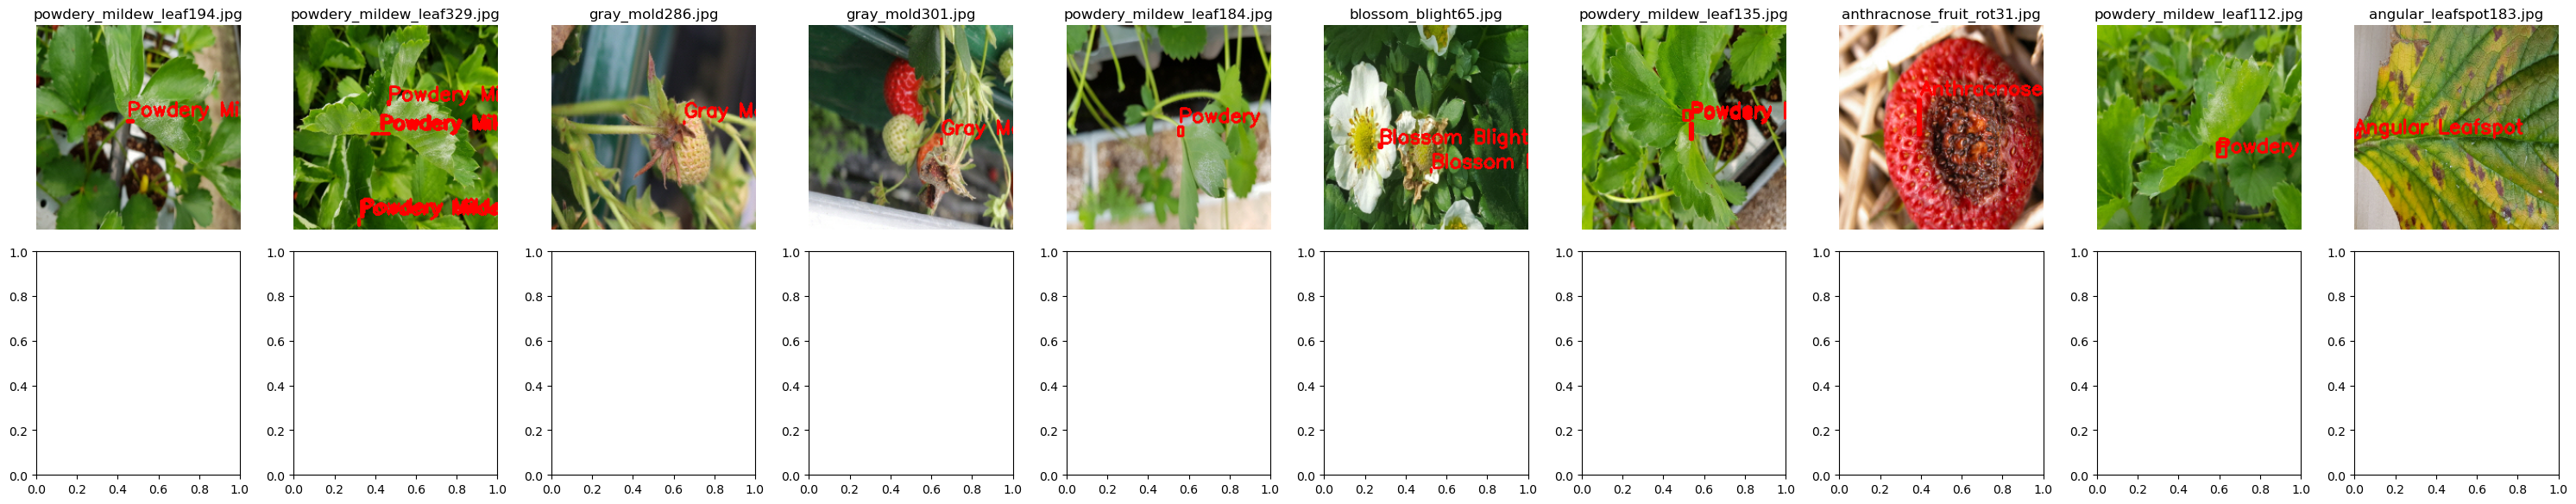

: 

In [ ]:
import os
import json
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

def load_random_images_with_bboxes(folder_path, num_images):
    """Load random images along with bounding boxes from JSON annotations."""
    images = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
    json_files = {f.replace(".json", ""): os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".json")}

    if not images:
        print(f"⚠️ Warning: No images found in {folder_path}!")
        return []

    selected_images = random.sample(images, min(num_images, len(images)))
    loaded_data = []

    for img_name in selected_images:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        # **Load JSON Annotation**
        json_path = json_files.get(img_name.replace(".jpg", ""))
        if not json_path or not os.path.exists(json_path):
            continue  # Skip images without annotations

        with open(json_path, "r") as f:
            annotation = json.load(f)

        img_width = annotation["imageWidth"]
        img_height = annotation["imageHeight"]

        # **Resize Image to (224, 224)**
        img_resized = cv2.resize(img, (224, 224)) / 255.0  # Normalize
        scale_x = 224 / img_width
        scale_y = 224 / img_height

        # **Extract Bounding Boxes**
        boxes = []
        labels = []
        for shape in annotation["shapes"]:
            label = shape["label"]
            points = shape["points"]
            x_min, y_min = points[0]
            x_max, y_max = points[1]

            # **Scale bounding box coordinates**
            x_min = int(x_min * scale_x)
            y_min = int(y_min * scale_y)
            x_max = int(x_max * scale_x)
            y_max = int(y_max * scale_y)

            boxes.append((x_min, y_min, x_max, y_max))
            labels.append(label)

        if boxes:
            loaded_data.append((img_name, img, img_resized, boxes, labels))
    
    return loaded_data

# Number of images to load
x = 10  # Change as needed

# Load `x` random images from object detection dataset (train, val, test)
train_samples = load_random_images_with_bboxes(os.path.join("../Kaggle/archive (1)", "train"), x)
val_samples = load_random_images_with_bboxes(os.path.join("../Kaggle/archive (1)", "val"), x)
test_samples = load_random_images_with_bboxes(os.path.join("../Kaggle/archive (1)", "test"), x)

# Display images with bounding boxes
fig, axes = plt.subplots(2, x, figsize=(x * 3, 6))

for i, sample in enumerate(train_samples[:2*x]):
    ax = axes[i // x, i % x]
    
    img_name, img, img_resized, boxes, labels = sample

    # **Convert Image to RGB for Display**
    img_display = cv2.resize(img, (224, 224))  # Resize for visualization
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

    # **Draw Ground Truth Bounding Boxes**
    for j, (x_min, y_min, x_max, y_max) in enumerate(boxes):
        cv2.rectangle(img_display, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Blue = Ground Truth
        cv2.putText(img_display, labels[j], (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    # **Show Image**
    ax.imshow(img_display)
    ax.set_title(img_name)
    ax.axis("off")

plt.tight_layout()
plt.show()
